**BSP 2025-2026/1**

**Total of 20 marks**

**Names/Neptun Codes:**

**Marks attained for this part of the homework will count towards your final grade.**

**To attain (full) marks for a question, any answer that includes images or a piece of knowledge, which should be referenced/cited, needs to highlight the source (book, article or web address). You are encouraged to help each other, but identical solutions will not be graded.**

**Write your codes to this document for the full marks. Rename the document to: BSP25_05_TEAM_MONOGRAM**

## Task 1 - The PCG recording (5 point)
In next lab, present the planned project and the preliminary data processing pipeline
The presentation should include:
    - The research objectives
    - The formulated hypothesis
    - The proposed methodology
    - The expected results and their scientific significance

## Task 2 - The PCG recording (1 point)
The signal a0191m was downloaded from the 2016 [Physionet Challenge database](https://archive.physionet.org/challenge/2016/), for the classification of normal-abnormal PCG recordings.

Plot the PCG signal and its spectrum.


## Task 3 - The abnormality (1 point)
*“The sound S2 is caused by the closure of the aortic and pulmonary valves. In some cases, both physiological and pathological, a split S2 is heard. With the split S2, the closure of the two valves does not occur together. Physiological S2 splitting in which the closing of the aortic valve precedes the closing of the pulmonic is normal. … Exaggerated splitting of the sound S2 may occur in right ventricular outflow tract obstruction (for example: pulmonary stenosis) and right bundle branch block (RBBB). … The wide split has a duration of about 50 ms compared to the normal split with the value .The measurement of the split S2, lower or higher than 30 ms, will easily make it possible to make a discrimination between the normal or pathological type."* [source](https://www.sciencedirect.com/science/article/pii/S0010482506000199)

Show splitting events on the plotted PCG signal. Are they physiological or pathological? (Use the ECG signal if you are unsure about the distinction of S1 and S2.)

## Task 4 - STFT (3 point)
Implement your version of the STFT function. It should have the following format:
function ***my_stft(signal,fs,windowtype,windowlength)***

short time fourier transform
**inputs**:
    - *signal*:     the ignal to take the transform of, 1D array
    - *fs*:         the sampling frequency of the signal
    - *windowtype*: 0 for rectangular, 1 for hann window
    - *widowsize*:  length of window in samples
**output**:
    - subplots of the signal and a 'one-sided' STFT spectrogram, with proper time and frequency axes


Example run with ***my_stft(PCG,fs,0,100)***

## Task 5 - TF-uncertainty (2 point)
Explain and illustrate the time-frequency uncertainty with the help of your code and signal. When are the splits visible/localizable? How does the window-type influence this difference?

## Task 6 - CWT vs STFT in theory (1 point)
Explain in your own words, how is the STFT different from the CWT.

## Task 7 - CWT in practice (1 point)
Use the cwt() function of PyWavelets to obtain the continuous wavelet transform of the PCG signal, and plot it. How is CWT discretized in Python? Which method would you recommend for detecting the split?

## Task 8 - pyPCG (5 point)

- Install pyPCG, read in the data and visualize it. Why is the sample rate so low?
- Show the spectrogram of a heart cycle from each example file. How does this relate to S1 split?
- Improve the example code with preprocessing or other methods. Give a reason for their inclusion.
- Calculate new features not shown in the example.
- Run your methods on the "non-example" files. Try to classify them.
- (Do not use the heart sound label file. Try to implement a peak detection method - extra point)

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq

In [2]:
def read_pcg(filename):
    fs, pcg = wavfile.read(filename)
    if pcg.ndim == 2:
        pcg = pcg.mean(axis=1)
    if np.issubdtype(pcg.dtype, np.integer):
        pcg = pcg.astype(np.float32) / np.iinfo(pcg.dtype).max
    return pcg, fs


In [3]:
file_path = 'Data/training-a/a0191.wav'
pcg, fs = read_pcg(file_path)

In [4]:
def plot_waveform(signal, fs, x, title, xlabel, ylabel):
    if x is None:
        t = np.arange(len(signal)) / fs
    else:
        t = x
    plt.figure(figsize=(12, 4))
    plt.plot(t, signal, linewidth=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

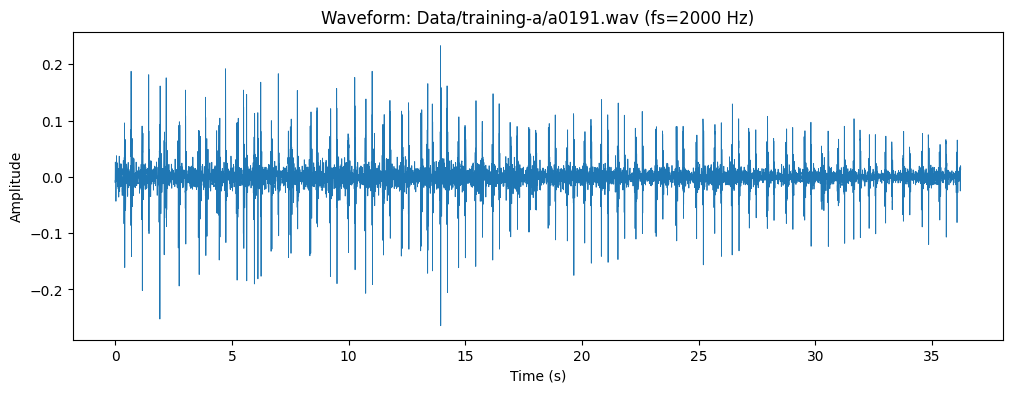

In [5]:
plot_waveform(pcg, fs, None, 'Waveform: ' + file_path + ' (fs=' + str(fs) + ' Hz)', 'Time (s)', 'Amplitude')

In [6]:
def compute_fft(x, fs):
    N = len(x)
    X = fft(x * np.hanning(N))  # apply window to reduce leakage
    freqs = fftfreq(N, 1.0/fs)
    # take positive freqs
    pos = freqs >= 0
    return freqs[pos], np.abs(X[pos]) / N

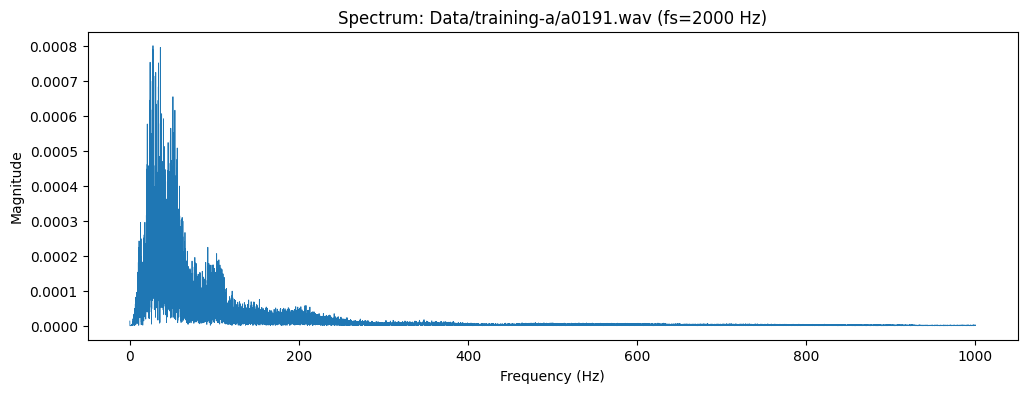

In [7]:
freqs, spectrum = compute_fft(pcg, fs)

plot_waveform(spectrum, fs, freqs, 'Spectrum: ' + file_path + ' (fs=' + str(fs) + ' Hz)', 'Frequency (Hz)', 'Magnitude')

In [8]:
def bandpass(x, fs, low=20, high=400, order=4):
    ny = fs / 2
    b, a = sig.butter(order, [low/ny, high/ny], btype='band')
    return sig.filtfilt(b, a, x)


In [9]:
pcg_filtered = bandpass(pcg, fs, low=20, high=400, order=4)

# Use squared envelope as a simple method
envelope = pcg_filtered**2

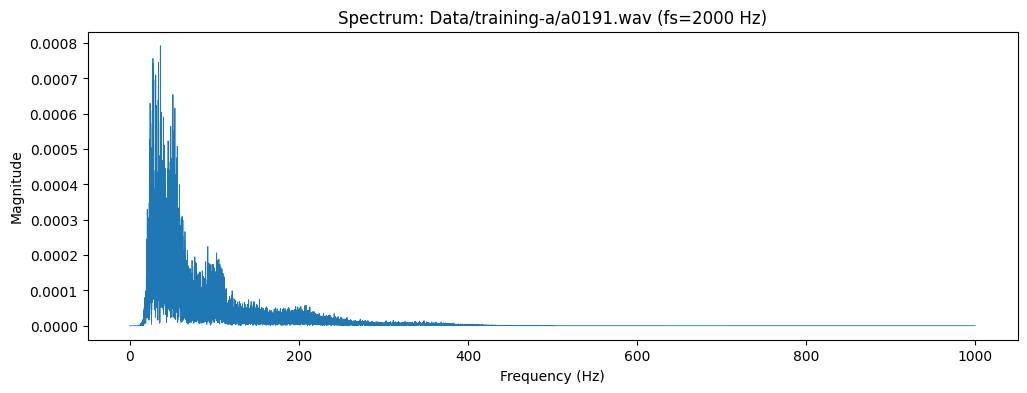

In [10]:
freqs, spectrum_filtered = compute_fft(pcg_filtered, fs)

plot_waveform(spectrum_filtered, fs, freqs, 'Spectrum: ' + file_path + ' (fs=' + str(fs) + ' Hz)', 'Frequency (Hz)', 'Magnitude')

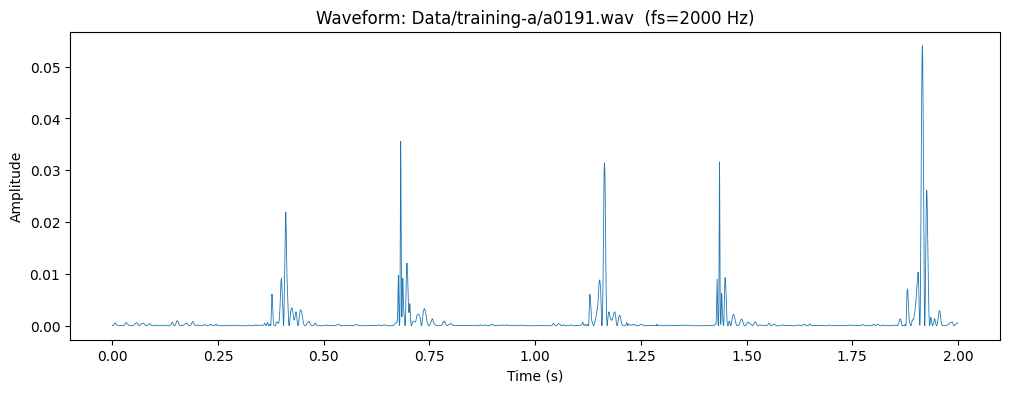

In [11]:
envelope_part = envelope[:2*fs]

plot_waveform(envelope_part, 
              fs, 
              None, 
              f'Waveform: {file_path}  (fs={fs} Hz)', 'Time (s)', 'Amplitude')

In [12]:
def detect_heart_sounds(pcg, fs):
    # envelope via Hilbert transform
    env = np.abs(sig.hilbert(pcg))
    env = sig.medfilt(env, kernel_size=15)
    # detect main peaks (S1 + S2)
    peaks, _ = sig.find_peaks(env, distance=int(0.2*fs), height=np.percentile(env, 75))
    return peaks, env


In [13]:
def classify_s1_s2(peaks, fs):
    # use interpeak intervals to alternate S1/S2
    intervals = np.diff(peaks) / fs
    # Systolic interval shorter than diastolic
    s1, s2 = [], []
    for i in range(len(intervals)):
        if intervals[i] < 0.4:  # short interval → S1→S2
            s1.append(peaks[i])
            s2.append(peaks[i+1])
    return np.array(s1), np.array(s2)


In [14]:
def detect_s2_splitting(pcg, s2_locs, fs):
    split_results = []
    for s2 in s2_locs:
        win = pcg[s2-int(0.05*fs):s2+int(0.05*fs)]
        if len(win) < 1: continue
        env = np.abs(sig.hilbert(win))
        env = sig.medfilt(env, kernel_size=9)
        peaks, _ = sig.find_peaks(env, distance=int(0.01*fs), height=np.max(env)*0.2)
        if len(peaks) >= 2:
            delta = (peaks[1] - peaks[0]) / fs * 1000  # ms
            split_type = "physiological" if delta < 30 else "pathological"
            split_results.append((s2, peaks[0], peaks[1], delta, split_type))
        else:
            split_results.append((s2, None, None, None, "no split"))
    return split_results


In [15]:
def plot_pcg_splitting(pcg, fs, s1, s2, split_results):
    t = np.arange(len(pcg)) / fs
    plt.figure(figsize=(14,4))
    plt.plot(t, pcg, label="PCG")
    plt.scatter(s1/fs, np.zeros_like(s1), marker='o', color='g', label='S1')
    plt.scatter(s2/fs, np.zeros_like(s2), marker='x', color='r', label='S2')

    for s2_loc, p1, p2, delta, label in split_results:
        if delta is not None:
            plt.axvline((s2_loc-int(0.05*fs)+p1)/fs, color='m', linestyle='--')
            plt.axvline((s2_loc-int(0.05*fs)+p2)/fs, color='c', linestyle='--')
            plt.annotate(f"{delta:.0f} ms ({label})", 
                         xy=(s2_loc/fs, np.max(pcg)*0.8), ha='center')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("PCG with detected S2 splitting")
    plt.tight_layout()
    plt.show()


S2 #1: Δt = 28.5 ms → physiological
S2 #2: Δt = 12.5 ms → physiological
S2 #3: Δt = 12.0 ms → physiological
S2 #4: Δt = 13.0 ms → physiological
S2 #5: Δt = 12.0 ms → physiological
S2 #6: Δt = 12.5 ms → physiological
S2 #7: Δt = 39.5 ms → pathological
S2 #8: Δt = 11.5 ms → physiological
S2 #9: Δt = 13.0 ms → physiological
S2 #10: Δt = 13.0 ms → physiological
S2 #11: Δt = 36.0 ms → pathological
S2 #12: Δt = 12.5 ms → physiological
S2 #13: Δt = 12.0 ms → physiological
S2 #14: Δt = 16.0 ms → physiological
S2 #15: Δt = 16.5 ms → physiological
S2 #16: Δt = 35.5 ms → pathological
S2 #17: Δt = 13.5 ms → physiological
S2 #18: Δt = 13.0 ms → physiological
S2 #19: Δt = 12.0 ms → physiological
S2 #20: Δt = 13.0 ms → physiological
S2 #21: Δt = 13.5 ms → physiological
S2 #22: Δt = 12.0 ms → physiological
S2 #23: Δt = 12.5 ms → physiological
S2 #24: Δt = 38.0 ms → pathological
S2 #25: Δt = 37.5 ms → pathological
S2 #26: Δt = 26.0 ms → physiological
S2 #27: Δt = 39.0 ms → pathological
S2 #28: Δt = 22.

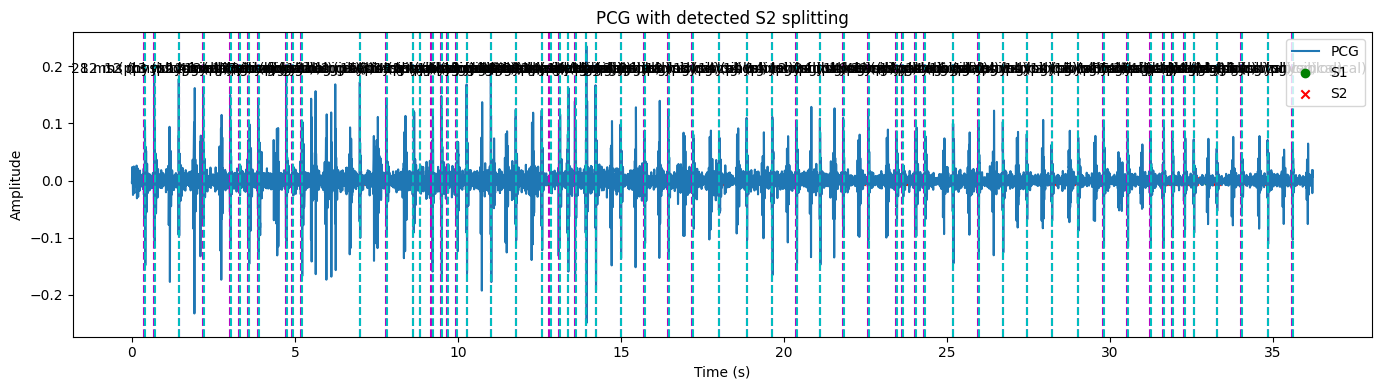

In [16]:
# --- load data ---
file_path = 'Data/training-a/a0191.wav'
pcg, fs = read_pcg(file_path)
# pcg = pcg[0:5*fs]  # analyze first 5 seconds

# --- analysis ---
pcg_f = bandpass(pcg, fs)
peaks, env = detect_heart_sounds(pcg_f, fs)
s1, s2 = classify_s1_s2(peaks, fs)
split_results = detect_s2_splitting(pcg_f, s2, fs)

# --- output ---
for i, (_, _, _, delta, label) in enumerate(split_results):
    print(f"S2 #{i+1}: Δt = {delta if delta else '—'} ms → {label}")

plot_pcg_splitting(pcg_f, fs, s1, s2, split_results)


In [17]:
def my_stft(signal, fs, windowtype, windowlength):
    """
    Short-Time Fourier Transform (STFT)
    
    Inputs:
        signal:       1D array-like signal
        fs:           sampling frequency (Hz)
        windowtype:   0 = rectangular window, 1 = Hann window
        windowlength: length of window in samples
    
    Output:
        Subplots of the signal and its one-sided STFT spectrogram
    """

    signal = np.asarray(signal)
    N = len(signal)
    hop_size = windowlength // 2  # 50% overlap
    num_frames = int(np.ceil((N - windowlength) / hop_size)) + 1

    # Select window type
    if windowtype == 0:
        window = np.ones(windowlength)
        wname = "Rectangular"
    elif windowtype == 1:
        window = np.hanning(windowlength)
        wname = "Hann"
    else:
        raise ValueError("windowtype must be 0 (rectangular) or 1 (hann).")

    # Pad signal if necessary
    padded_length = (num_frames - 1) * hop_size + windowlength
    if padded_length > N:
        signal = np.pad(signal, (0, padded_length - N), mode='constant')

    # Initialize STFT matrix
    stft_matrix = np.zeros((windowlength // 2 + 1, num_frames), dtype=np.complex64)

    # Compute STFT
    for i in range(num_frames):
        start = i * hop_size
        frame = signal[start:start + windowlength] * window
        spectrum = np.fft.rfft(frame)
        stft_matrix[:, i] = spectrum

    # Compute time and frequency axes
    freqs = np.fft.rfftfreq(windowlength, d=1/fs)
    times = np.arange(num_frames) * hop_size / fs

    # Convert magnitude to dB scale
    magnitude_db = 20 * np.log10(np.abs(stft_matrix) + 1e-12)

    # Plot signal and STFT spectrogram
    plt.figure(figsize=(10, 6))

    # Time-domain signal
    plt.subplot(2, 1, 1)
    t = np.arange(N) / fs
    plt.plot(t, signal[:N])
    plt.title(f"Time Domain Signal (Window: {wname})")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(times, freqs, magnitude_db, shading='auto')
    plt.title("One-Sided STFT Magnitude Spectrogram (dB)")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label="Magnitude [dB]")
    plt.tight_layout()
    plt.show()


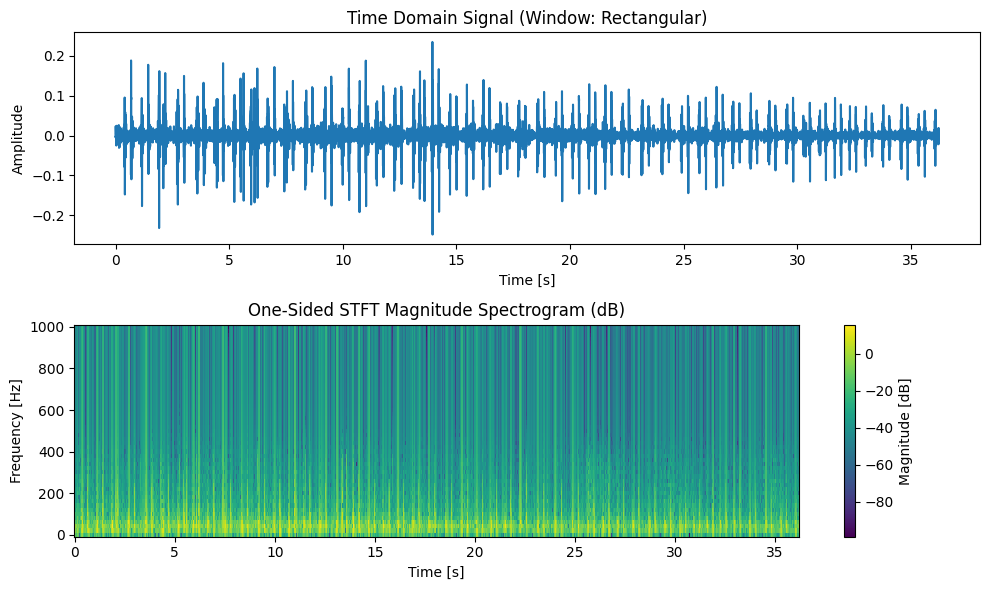

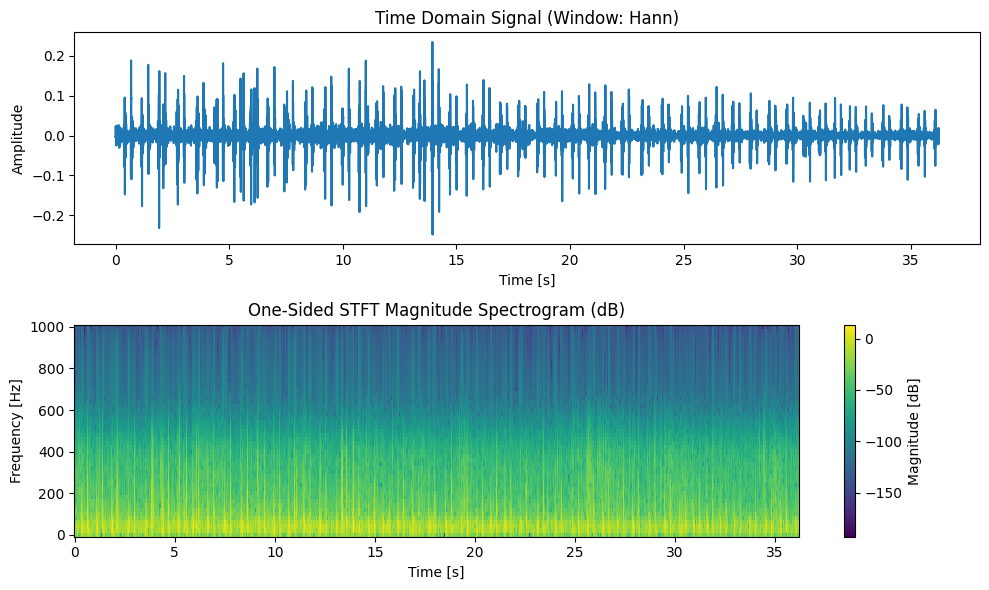

In [18]:
my_stft(pcg_f, fs, 0, 100)
my_stft(pcg_f, fs, 1, 100)

## 5.
In time domain time resolution is the best and frequency resolution is zero. In frequency domain time frequency is zero and frequency resolution is the best. Between the to the window size determines the tradeoff between the two. 

The split is more easyly observable with rectangular window.

## 6.
The STFT uses a fixed-size window, giving the same time and frequency resolution across all frequencies.

The CWT uses variable-sized wavelets, giving good time resolution at high frequencies and good frequency resolution at low frequencies.

## 7.

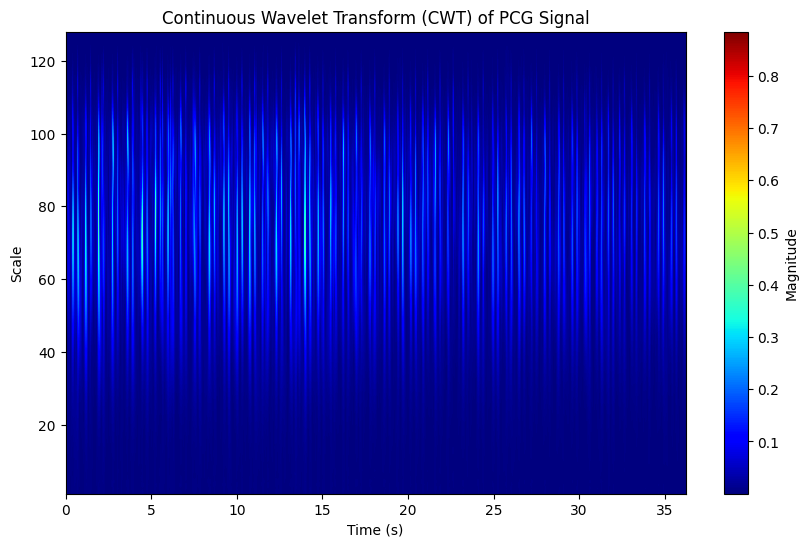

In [19]:
from pywt import cwt
coeffs, frequencies = cwt(pcg_f, scales=np.arange(1, 128), wavelet='morl', sampling_period=1/fs)
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, len(pcg_f)/fs, 1, 128], cmap='jet')
plt.colorbar(label='Magnitude')
plt.ylabel('Scale')
plt.xlabel('Time (s)')
plt.title('Continuous Wavelet Transform (CWT) of PCG Signal')
plt.show()


In Python, the Continuous Wavelet Transform (CWT) is discretized by computing it at a finite set of scales (instead of all possible ones) and at discrete time steps (based on the signal’s sampling rate).

I would recommend CWT because of its better resolution and lower noise level.